# Import everyting here

In [1]:
import torch.utils.data
import matplotlib.pyplot as plt
import scipy.integrate
import numpy as np

from data_module import *
from Euler import *

%reload_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
save_location = "./figures/alpha_1,3_"

# Setup Tensorboard

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

Launching TensorBoard...

# Create dataset

In [5]:
alpha = 1.3
delta_t = 0.05
t_eval = np.arange(0, 5, delta_t)

dataset = create_dataset(alpha, t_eval, 100)

# Reshape dataset

In [6]:
dataset = reshape_dataset(dataset)

# Split dataset

In [7]:
training_set, validation_set, test_set = split_dataset(dataset, 0.6, 0.2, 0.2)

# Define hyperparameters

In [8]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [9]:
model = Euler(hparams)

# Validation set

Score of the Model before training: 254.64911688073624


Text(0.5, 0, '$x_2$')

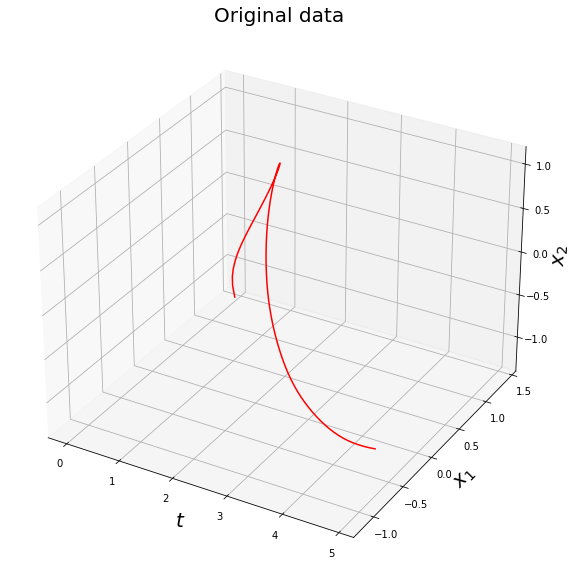

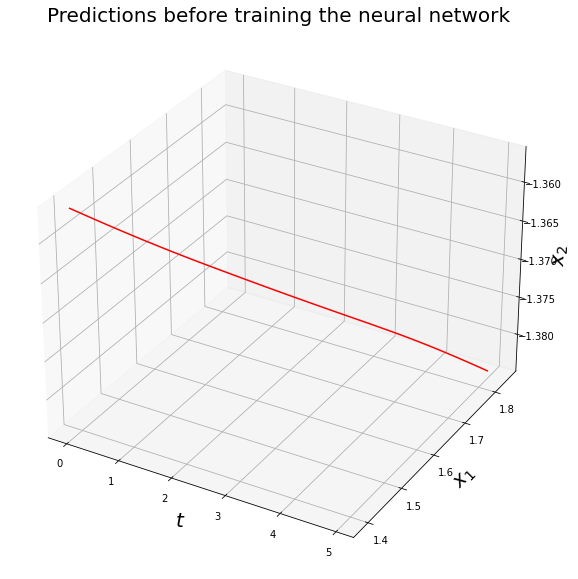

In [10]:
# plot the first one
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(np.delete(t_eval, -1, 0), validation_set[:99, 0, 0], validation_set[:99, 0, 1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_title("Original data", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "original_data.png")

print("Score of the Model before training:", evaluate_model(model, validation_set, hparams, device))

# plot the first one
recreation = recreate_trajectory(model, validation_set[0, 0, :], t_eval[0], t_eval[-1], delta_t, device)
recreation = np.array(recreation)

fig0 = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[:, 0], recreation[:, 1], color="r")

ax0.set_title("Predictions before training the neural network", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig0.savefig(save_location + "pred_b_train.png");

In [11]:
train_dataloader = torch.utils.data.DataLoader(training_set,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)
validation__dataloader = torch.utils.data.DataLoader(validation_set,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)

In [12]:
trainer = pl.Trainer(
    max_epochs=1,
    log_every_n_steps=5,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Score of the Model after training: 1805.7349729638595


Text(0.5, 0, '$x_2$')

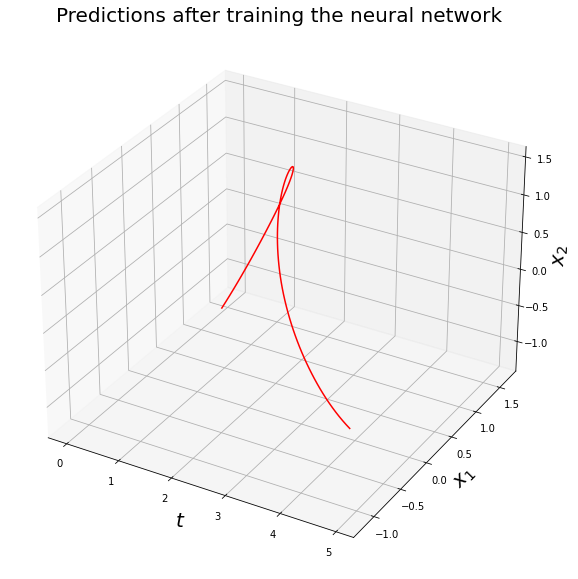

In [13]:
print("Score of the Model after training:", evaluate_model(model, validation_set, hparams, device))

# plot the first one
recreation = recreate_trajectory(model, validation_set[0, 0, :], t_eval[0], t_eval[-1], delta_t, device)
recreation = np.array(recreation)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[:, 0], recreation[:, 1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_title("Predictions after training the neural network", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "pred_a_train.png");

Text(0, 0.5, '$x_2$')

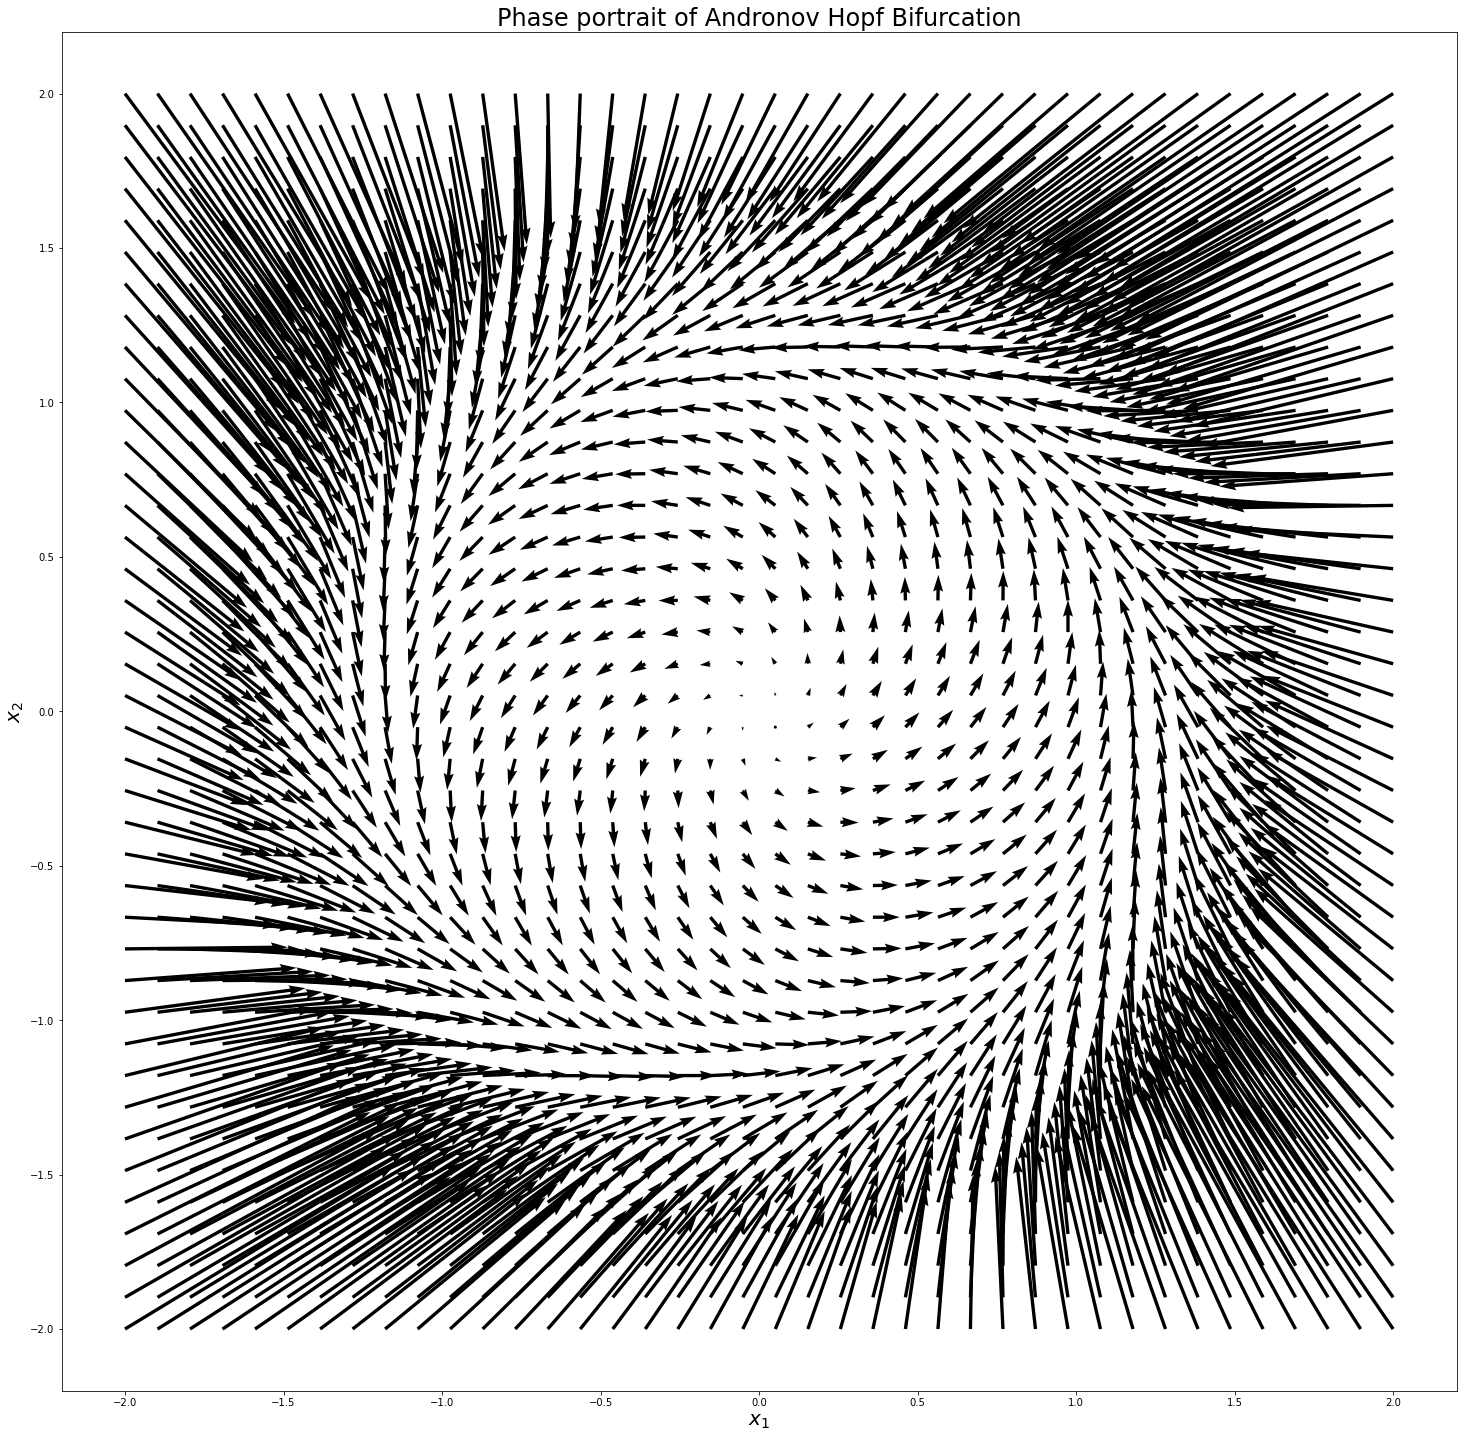

In [20]:
positions = np.empty((40, 40, 2))
next_positions = np.empty((40, 40, 2))
for idx1, i in enumerate(np.linspace(-2, 2, 40)):
    for idx2, j in enumerate(np.linspace(-2, 2, 40)):
        positions[idx1][idx2] = np.array((i, j))
        position = torch.tensor((i, j))
        next_positions[idx1][idx2] = (model(position.float())).detach().numpy()
derivatives = (next_positions - positions) / delta_t
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot()
ax.quiver(positions[:, :, 0], positions[:, :, 1], derivatives[:, :, 0], derivatives[:, :, 1], units="xy", scale=10)
ax.set_title(r"Phase portrait of Andronov Hopf Bifurcation", fontsize=24)
ax.set_xlabel(r"$x_1$", fontsize=20)
ax.set_ylabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "phase_portrait.png");